In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [21]:
def generate_interior_data(filename, var, nx=None, nz=None, device='cpu'):
    """
    Read CSV data and return torch tensors.
    Array containing the u values reshaped to (nx, nz) if dimensions provided,
    otherwise returns the raw data as torch tensors
    """
    try:
        # Read the CSV file
        data = pd.read_csv(filename)
        
        # Verify the required columns exist
        required_cols = ['x', 'z', var]
        if not all(col in data.columns for col in required_cols):
            raise ValueError(f"CSV must contain columns: {required_cols}")
        
        # Create coordinate tensor
        X_data_np = np.column_stack((data['x'].values, data['z'].values))
        X_data = torch.tensor(X_data_np, dtype=torch.float64, requires_grad=True, device=device)
        
        if nx is not None and nz is not None:
            # Get unique x and z values
            unique_x = np.sort(data['x'].unique())
            unique_z = np.sort(data['z'].unique())
            
            # Verify the dimensions match
            if len(unique_x) != nx or len(unique_z) != nz:
                raise ValueError(f"Data dimensions ({len(unique_x)}, {len(unique_z)}) "
                               f"don't match specified dimensions ({nx}, {nz})")
            
            # Reshape the data into a 2D grid and convert to torch tensor
            u_values = data[var].values.reshape((nx, nz))
            u_data = torch.tensor(u_values, dtype=torch.float64, device=device)
        else:
            # Return the raw data as torch tensor if dimensions aren't specified
            u_data = torch.tensor(data[var].values, dtype=torch.float32, device=device)
            
        return X_data, u_data
            
    except Exception as e:
        print(f"Error reading or processing data: {str(e)}")
        raise


In [2]:
from generate_data_points import generate_interior_data


X_data, u_data = generate_interior_data('data/imag_part_0.0120Hz.csv','u')  # for raw data


In [139]:
len(u_data)

58081

In [8]:
from generate_data_points import sample_interior_data3


X_data_, u_data_ = sample_interior_data3(X_data, u_data, num_samples=10000, device='cpu')


ImportError: cannot import name 'sample_interior_data3' from 'generate_data_points' (/home/sagemaker-user/tdg/ML-for-FWI-geophysics/tests_devito/inverse/generate_data_points.py)

In [149]:
# Basic printing of first few elements
print("First 5 elements of X_data:")
print(X_data_[:5])
print("\nFirst 5 elements of u_data:")
print(u_data_[:5])



First 5 elements of X_data:
tensor([[579.1666, 275.0000],
        [529.1666, 437.5000],
        [283.3333, 479.1667],
        [512.5000, 241.6667],
        [375.0000, 766.6666]], dtype=torch.float64, grad_fn=<SliceBackward0>)

First 5 elements of u_data:
tensor([ 14.2381,  15.6109,  31.0093,   6.3498, -23.5932])


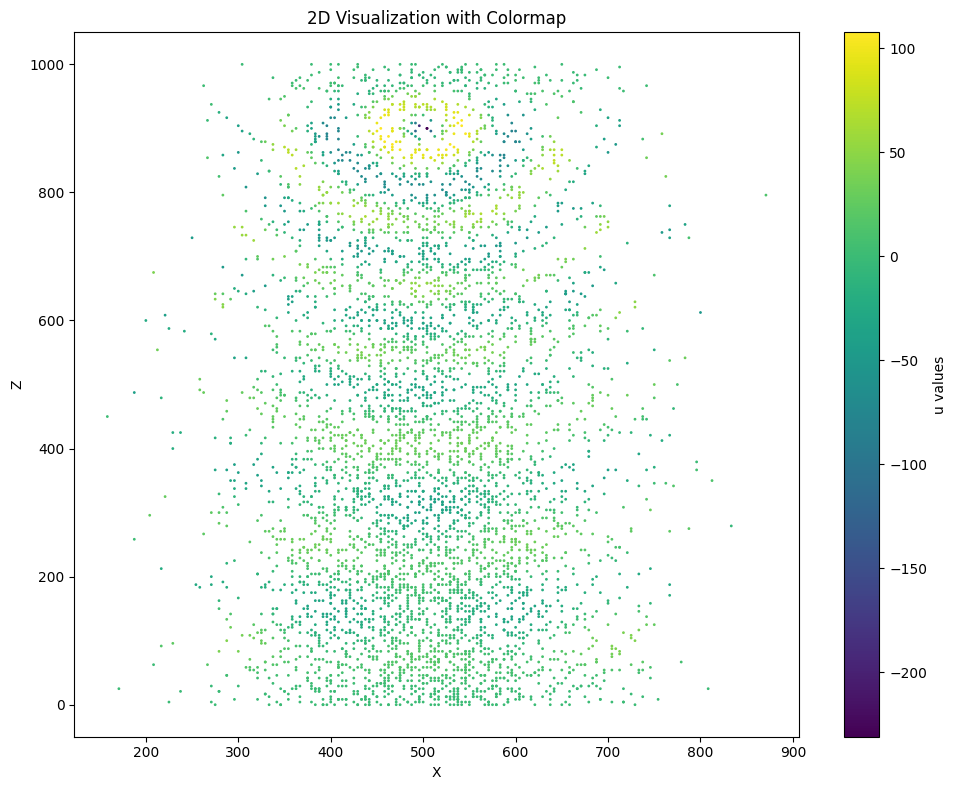

In [153]:
import matplotlib.pyplot as plt

# Extract x and z coordinates from X_data
x = X_data_[:, 0].detach().numpy()
z = X_data_[:, 1].detach().numpy()
u = u_data_.detach().numpy()
# Create the scatter plot with colormap
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x, z, c=u, cmap='viridis', s = 1)
plt.colorbar(scatter, label='u values')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Z')
plt.title('2D Visualization with Colormap')

# Adjust the layout and display
plt.tight_layout()
plt.show()

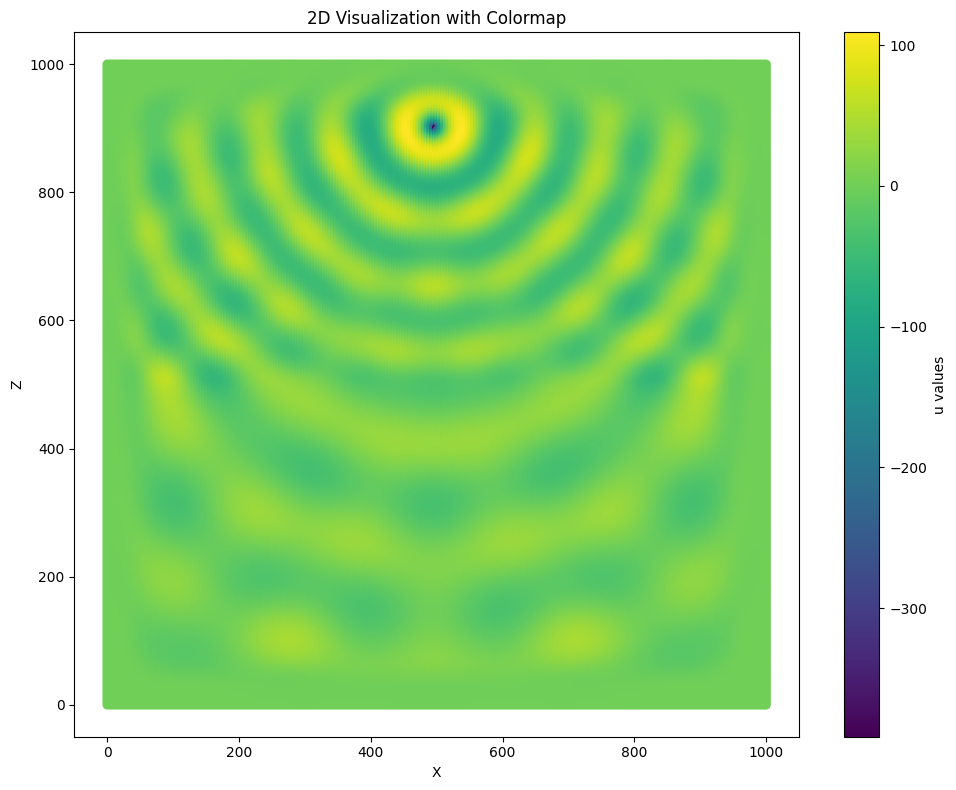

In [34]:
import matplotlib.pyplot as plt

# Extract x and z coordinates from X_data
x = X_data[:, 0].detach().numpy()
z = X_data[:, 1].detach().numpy()
u = u_data.detach().numpy()

# Create the scatter plot with colormap
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x, z, c=u, cmap='viridis')
plt.colorbar(scatter, label='u values')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Z')
plt.title('2D Visualization with Colormap')

# Adjust the layout and display
plt.tight_layout()
plt.show()


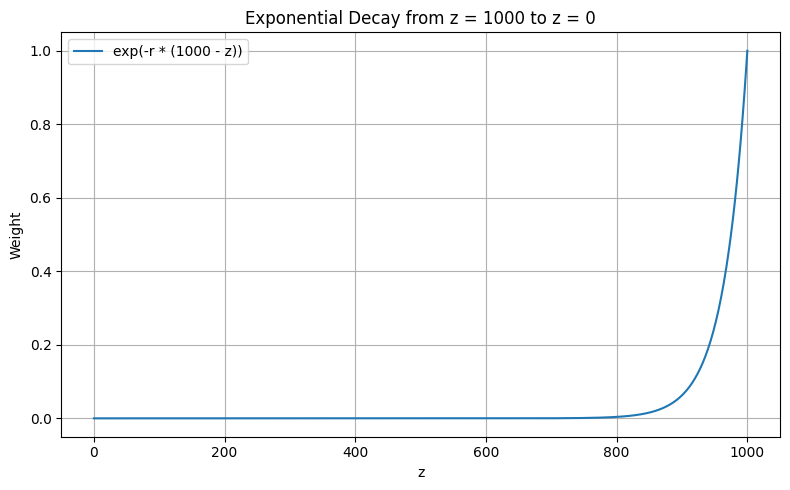

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
z_max = 1000.0
z_decay_rate = 0.0277  # ajusta este valor si necesitas otro decay
z_coords = np.linspace(0, z_max, 1000)

# Cálculo de pesos
z_weights = np.exp(-z_decay_rate * (z_max - z_coords))

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(z_coords, z_weights, label='exp(-r * (1000 - z))')
plt.xlabel("z")
plt.ylabel("Weight")
plt.title("Exponential Decay from z = 1000 to z = 0")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
